In [1]:
import os
import math
import time
import numpy as np
import pandas as pd

import pyarrow
import fastparquet

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader

# Pytorch Lightening
import pytorch_lightning as pl

# For Visualization
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline     
sns.set(color_codes=True)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# local imports
from data_loading import load_data, SNPDataModule

In [4]:
input_file = "HO_data/HO_data_filtered/HumanOrigins2067_filtered.parquet"

In [5]:
snp_data = load_data(input_file)

In [6]:
snp_data.shape

torch.Size([160858, 2067])

In [7]:
# Verification
unique_values = np.unique(snp_data)
print("Unique values after normalization:", unique_values)  # Should show [0.0, 0.5, 1.0, 9.0]

Unique values after normalization: [0.  0.5 1.  9. ]


- _LightningDataModule_

In [8]:
# initialize DataModule
snp_data_module = SNPDataModule(input_path=input_file, batch_size=256, num_workers=1)

In [9]:
# Setup Data
snp_data_module.setup()

In [10]:
# Train DataLoader
train_loader = snp_data_module.train_dataloader()

In [11]:
# Get a batch from DataLoader
sample_batch = next(iter(train_loader))

In [12]:
print("Batch Shape:", sample_batch.shape)  # Expected: (batch_size, num_markers)
print("First 5 Samples:\n", sample_batch[:5])  # Show first 5 rows

Batch Shape: torch.Size([256, 2067])
First 5 Samples:
 tensor([[0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 0.0000],
        [0.5000, 0.0000, 0.0000,  ..., 0.5000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000]])


In [13]:
x0 = sample_batch[0]
x0.shape

torch.Size([2067])

### 1. Sinusoidal Positional Embeddings

In [15]:
# import from model.py (import only corrected versions)
from model import SinusoidalPositionalEmbeddings, UniformDiscreteTimeSampler

#### _1.1 Linear Time Sampler with SinusoidalPositionalEmbeddings_

time shape: torch.Size([1000])
embedding shape: torch.Size([1000, 500])


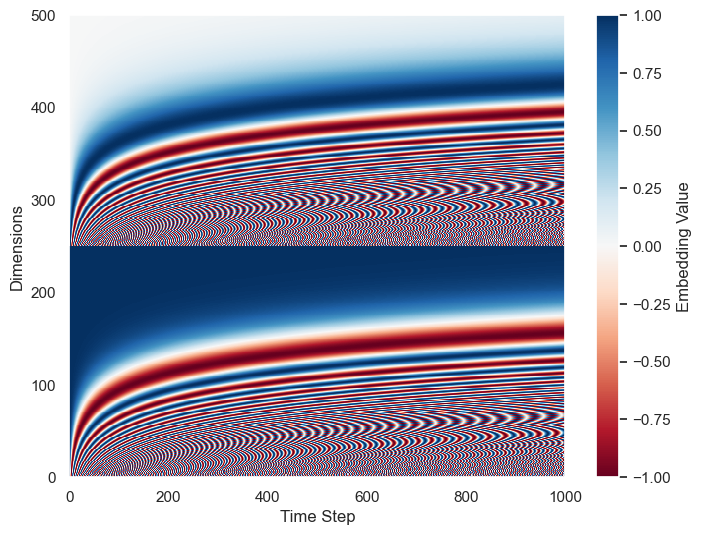

In [16]:
# Linear time sampler
timesteps = 1000  # Number of time steps
time = torch.arange(timesteps, dtype=torch.float32)  # Linear time sampler
print(f"time shape: {time.shape}")

# Sinusoidal Positional Embeddings
embedding_dim = 500  # Embedding dimensions
position_emb = SinusoidalPositionalEmbeddings(dim=embedding_dim)
emb = position_emb(time)  # Shape: [1000, 500]
print(f"embedding shape: {emb.shape}")

# Plot the embeddings
plt.figure(figsize=(8,6))
plt.pcolormesh(emb.T, cmap='RdBu', shading='auto')  # Transpose to align time on x-axis
plt.ylabel('Dimensions')
plt.xlabel('Time Step')
plt.colorbar(label="Embedding Value")
plt.show()

#### _1.2 Uniform Time Sampler with SinusoidalPositionalEmbeddings_

time shape: torch.Size([1000])
embedding shape: torch.Size([1000, 500])


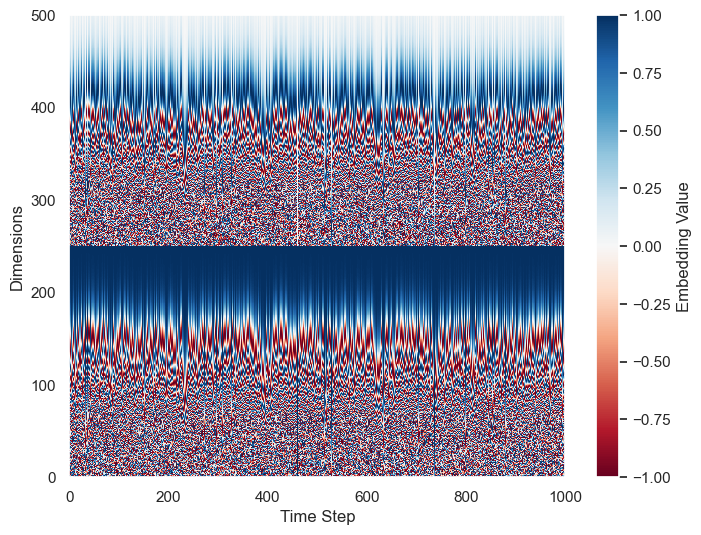

In [17]:
# Linear time sampler
timesteps = 1000  # Number of time steps
time_sampler = UniformDiscreteTimeSampler(tmin=0, tmax=timesteps)
time = time_sampler.sample(shape=(timesteps,))  # Uniform time sampler
print(f"time shape: {time.shape}")

# Sinusoidal Positional Embeddings
embedding_dim = 500  # Embedding dimensions
position_emb = SinusoidalPositionalEmbeddings(dim=embedding_dim)
emb = position_emb(time)  # Shape: [1000, 500]
print(f"embedding shape: {emb.shape}")

# Plot the embeddings
plt.figure(figsize=(8,6))
plt.pcolormesh(emb.T, cmap='RdBu', shading='auto')  # Transpose to align time on x-axis
plt.ylabel('Dimensions')
plt.xlabel('Time Step')
plt.colorbar(label="Embedding Value")
plt.show()

- By adding this Time Embedding to the hidden layer value, we can add time information to the hidden layer value.

In [18]:
# time sample: tmin=0, tmax=1000, 
time_sampler = UniformDiscreteTimeSampler(tmin=0, tmax=1000)
time = time_sampler.sample(shape=(timesteps,))  # sample time

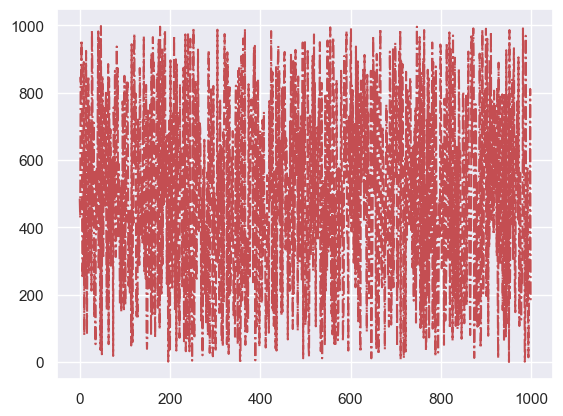

In [19]:
plt.plot(time, "r-.")

In [22]:
emb.shape

torch.Size([1000, 500])

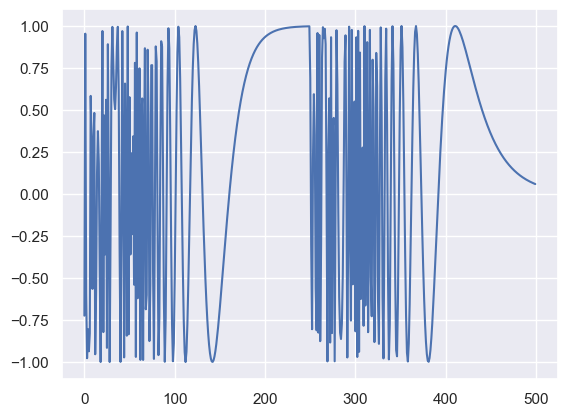

In [23]:
plt.plot(emb[0])

### _2. DDPM Process_

- _Adding Gussian Noise to the Input Data (Forward Process)_

In [24]:
from model import DDPMProcess

In [25]:
# create the model
time_steps = 1000
diffusion_process = DDPMProcess(num_diffusion_timesteps=time_steps, beta_start=0.00001, beta_end=0.02)
time_sampler = UniformDiscreteTimeSampler(tmin=diffusion_process.tmin, tmax=diffusion_process.tmax)

In [26]:
# x0 = sample_batch[0]  # i.e. input data, one example from a batch
t = time_sampler.sample(shape=(x0.shape[0],))
eps = torch.randn_like(x0, device=x0.device)  # Sample noise
xt = diffusion_process.sample(x0, t, eps)  # corrupted input data

In [27]:
x0

tensor([0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000])

In [28]:
xt

tensor([[ 0.3787,  0.3766, -1.8656,  ...,  1.0890, -0.2380,  0.1910],
        [ 0.3475,  0.5219, -1.7117,  ...,  0.9992, -0.2184,  0.1752],
        [ 0.3792,  0.3590, -1.8679,  ...,  1.0904, -0.2383,  0.1912],
        ...,
        [ 0.0276,  0.5242, -0.1357,  ...,  0.0792, -0.0173,  0.0139],
        [ 0.3790,  0.3672, -1.8672,  ...,  1.0899, -0.2382,  0.1912],
        [ 0.3293,  0.5527, -1.6223,  ...,  0.9470, -0.2070,  0.1661]])

- **Visualize Diffusion (`x0` and `xt`)?**

### _Denoising Process_

- _Denoisng the Corrupted Input Data (Backward Process)_

In [ ]:
# now denoise xt to recover x0
# denoising_process = Unet(.....)   # time, x, ....???

## _Diffusion Model_

In [36]:
from model import DiffusionModel, NetConfig

In [26]:
model = DiffusionModel(diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(6,))

In [27]:
model

DiffusionModel(
  (net_fwd): Net(
    (_time_encoder): SinusoidalTimeEmbedding()
    (_predictor): ResidualConv1D(
      (conv1): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (label_emb): Embedding(3, 256)
    )
  )
)